In [1]:
%matplotlib inline
# Bibliothèques Python
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# Bibliothèques PyTorch
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# Bibliothèques scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assurer la reproductibilité des résultats
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# Vérification du contenu du répertoire
print(os.listdir('/kaggle/input/'))

['skin-cancer-mnist-ham10000']


In [2]:
# Vérification du contenu du répertoire d'images
print(os.listdir('../input/skin-cancer-mnist-ham10000'))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [3]:
# Définir le répertoire des données
data_dir = '../input/skin-cancer-mnist-ham10000'

# Récupérer les chemins des images (fichiers .jpg)
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))

# Créer un dictionnaire pour associer l'ID de l'image au chemin
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Dictionnaire des types de lésions cutanées
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
import cv2
import numpy as np
from tqdm import tqdm

def compute_img_mean_std(image_paths):
    """
    Computing the mean and std of three channels for the whole dataset,
    first we should normalize the image from 0-255 to 0-1.
    
    Note: This is adjusted for InceptionV3 which requires 299x299 input size.
    """
    
    # Set the target size to 299x299 for InceptionV3
    img_h, img_w = 299, 299
    imgs = []
    means, stdevs = [], []

    # Loop through each image in the dataset
    for i in tqdm(range(len(image_paths))):
        # Read the image
        img = cv2.imread(image_paths[i])
        
        # Resize the image to 299x299
        img = cv2.resize(img, (img_w, img_h))
        
        # Append the resized image to the list
        imgs.append(img)

    # Stack images into a numpy array (shape: [height, width, channels, num_images])
    imgs = np.stack(imgs, axis=3)  # [H, W, C, N]
    print(imgs.shape)  # [299, 299, 3, N]

    # Convert images to float32 and normalize to [0, 1]
    imgs = imgs.astype(np.float32) / 255.0

    # Compute the mean and std for each channel (RGB)
    for i in range(3):  # Loop through the 3 channels (RGB)
        # Flatten the pixel values of the i-th channel
        pixels = imgs[:, :, i, :].ravel()  # Flatten to a 1D array
        means.append(np.mean(pixels))  # Calculate mean
        stdevs.append(np.std(pixels))  # Calculate standard deviation

    # Reverse the lists to match RGB order (OpenCV loads images in BGR)
    means.reverse()  
    stdevs.reverse()

    # Print the calculated mean and standard deviation values
    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))

    # Return the mean and standard deviation
    return means, stdevs


In [5]:
# Valeurs moyennes et écart-types normalisés pour les canaux R, G, B
norm_mean = [0.7630392, 0.5456477, 0.57004845]
norm_std = [0.1409286, 0.15261266, 0.16997074]

In [6]:
# Chargement des métadonnées
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

# Ajout du chemin d'accès à chaque image
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)

# Ajout du type de lésion cutanée à partir du dictionnaire
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)

# Conversion du type de lésion en indices numériques
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [7]:
# Regroupement par 'lesion_id' et comptage des occurrences
df_undup = df_original.groupby('lesion_id').count()

# Filtrer les 'lesion_id' qui ont seulement une image associée
df_undup = df_undup[df_undup['image_id'] == 1]

# Réinitialisation de l'index pour simplifier l'accès
df_undup.reset_index(inplace=True)

df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [8]:
# Fonction pour identifier les doublons dans les lésions
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# Création d'une nouvelle colonne qui est une copie de la colonne 'lesion_id'
df_original['duplicates'] = df_original['lesion_id']

# Application de la fonction pour marquer les doublons
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)

df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated


In [9]:
# Comptage des valeurs dans la colonne 'duplicates' pour savoir combien de doublons et non-doublons il y a
df_original['duplicates'].value_counts().reset_index(name='count')

,duplicates,count
0,unduplicated,5514
1,duplicated,4501


In [10]:
# Filtrer les lésions qui sont marquées comme 'unduplicated'
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [11]:
y = df_undup['cell_type_idx']

# Création d'un ensemble de validation en utilisant train_test_split
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)

# Affichage de la forme de l'ensemble de validation pour vérifier sa taille
df_val.shape

(1103, 11)

In [12]:
# Vérification de la répartition des classes dans l'ensemble de validation
df_val['cell_type_idx'].value_counts().reset_index(name='count')

,cell_type_idx,count
0,4,883
1,2,88
2,6,46
3,1,35
4,0,30
5,5,13
6,3,8


In [13]:
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows
# Create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# Apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# Filter out training rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [14]:
df_train['cell_type_idx'].value_counts().reset_index(name='count')

,cell_type_idx,count
0,4,5822
1,6,1067
2,2,1011
3,1,479
4,0,297
5,5,129
6,3,107


In [15]:
df_val['cell_type'].value_counts().reset_index(name='count')

,cell_type,count
0,Melanocytic nevi,883
1,Benign keratosis-like lesions,88
2,dermatofibroma,46
3,Basal cell carcinoma,35
4,Actinic keratoses,30
5,Vascular lesions,13
6,Dermatofibroma,8


In [16]:
import torch

# Vérifiez si CUDA (GPU) est disponible
cuda_available = torch.cuda.is_available()
print(f"CUDA is available: {cuda_available}")

# Si le GPU est disponible, utilisez-le, sinon utilisez le CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Affichez le nom du GPU, si disponible
if cuda_available:
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU found.")

# Exemple de tensor déplacé vers le GPU
tensor = torch.randn(3, 3).to(device)
print(f"Tensor on device: {tensor.device}")


CUDA is available: True
GPU Name: Tesla T4
Tensor on device: cuda:0


In [17]:
import pandas as pd

# Initialiser les taux d'augmentation souhaités
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]

# Calculer le nombre maximum d'exemples parmi toutes les classes (pour le but d'équilibrage)
max_size = df_train['cell_type'].value_counts().max()

# Créer un DataFrame pour enregistrer les nouvelles données augmentées
augmented_data = []

# Boucle sur chaque classe et augmenter de manière équilibrée
for i in range(7):
    # Récupérer le sous-ensemble de données pour chaque classe
    class_data = df_train[df_train['cell_type_idx'] == i]
    
    # Calculer le nombre d'exemples à augmenter pour atteindre la taille cible
    target_size = max_size  # ou une taille cible définie manuellement
    current_size = len(class_data)
    augmentation_factor = (target_size // current_size)  # combien de fois multiplier les données de la classe
    
    # Si augmentation nécessaire
    if augmentation_factor > 1:
        augmented_class_data = pd.concat([class_data] * augmentation_factor, ignore_index=True)
        augmented_data.append(augmented_class_data)

# Concaténer toutes les classes augmentées avec les données d'origine
df_train_augmented = pd.concat([df_train] + augmented_data, ignore_index=True)

# Vérifier les nouvelles valeurs de 'cell_type' après augmentation
print(df_train_augmented['cell_type'].value_counts())

cell_type
dermatofibroma                    6402
Basal cell carcinoma              6227
Benign keratosis-like lesions     6066
Actinic keratoses                 5940
Vascular lesions                  5934
Dermatofibroma                    5885
Melanocytic nevi                  5822
Name: count, dtype: int64


In [18]:
# Split the test set again in a validation set and a true test set:
df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

print(len(df_test))
df_test['cell_type'].value_counts()

552


cell_type
Melanocytic nevi                  444
Benign keratosis-like lesions      47
dermatofibroma                     20
Basal cell carcinoma               15
Actinic keratoses                  12
Vascular lesions                    8
Dermatofibroma                      6
Name: count, dtype: int64

In [19]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [20]:
import torch
import torch.nn as nn
from torchvision import models

# Fonction pour initialiser le modèle
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    # Vérifier si le modèle demandé est 'inception'
    if model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        # Charger le modèle InceptionV3 avec des poids pré-entraînés (ImageNet par défaut)
        model_ft = models.inception_v3(pretrained=use_pretrained)

        # Fonction pour geler ou ajuster les paramètres du modèle selon l'option 'feature_extract'
        set_parameter_requires_grad(model_ft, feature_extract)

        # Traiter le réseau auxiliaire (AuxLogits)
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

        # Traiter le réseau principal (fc)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

        # Définir la taille d'entrée attendue par le modèle
        input_size = 299  # Taille d'entrée pour InceptionV3

    else:
        # Si le modèle spécifié n'est pas supporté, afficher un message d'erreur et arrêter l'exécution
        print("Nom du modèle invalide, sortie...")
        exit()

    # Retourner le modèle initialisé et la taille d'entrée
    return model_ft, input_size



In [21]:
import torch

# Paramètres du modèle
model_name = "inception"  # Choix du modèle (ici InceptionV3)
num_classes = 7  # Nombre de classes pour la classification
feature_extract = False  # Indique si on veut uniquement extraire des caractéristiques (True) ou entraîner entièrement (False)

# Initialisation du modèle avec les paramètres définis ci-dessus
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Définir l'appareil (GPU ou CPU) sur lequel le modèle sera exécuté
device = torch.device('cuda:0')  # Utilisation du GPU (cuda:0 pour le premier GPU disponible)
# Si vous souhaitez utiliser le CPU au lieu du GPU, vous pouvez décommenter la ligne suivante :
# device = torch.device('cpu')  # Utilisation du CPU

# Déplacer le modèle sur l'appareil sélectionné (GPU ou CPU)
model = model_ft.to(device)

# Vérification que le modèle est bien sur l'appareil choisi
print(f"Le modèle est placé sur : {device}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 209MB/s] 


Le modèle est placé sur : cuda:0


In [22]:
# Définir les transformations pour les images d'entraînement
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(norm_mean, norm_std)])

# Définir les transformations pour les images de validation
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

# Définir les transformations pour les images de test
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                     transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [23]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [24]:
# Définir l'ensemble d'entraînement en utilisant le DataFrame train_df et les transformations définies (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Définir de la même manière l'ensemble de validation :
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# Définir de la même manière l'ensemble de test :
test_set = HAM10000(df_test, transform=train_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)


In [25]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from typing import Optional, List
from torch.nn.modules.loss import _Loss

# Constants for mode
BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

# Dice Loss class
class DiceLoss(_Loss):
    def __init__(
        self,
        mode: str,
        classes: Optional[List[int]] = None,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.0,
        ignore_index: Optional[int] = None,
        eps: float = 1e-7,
    ):
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            self.classes = torch.tensor(classes, dtype=torch.long)
        else:
            self.classes = None
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss
        self.ignore_index = ignore_index

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)
                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)
            else:
                y_true = F.one_hot(y_true, num_classes)
                y_true = y_true.permute(0, 2, 1)

        scores = self.compute_score(
            y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims
        )

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

    def compute_score(
        self, output, target, smooth=0.0, eps=1e-7, dims=None
    ) -> torch.Tensor:
        intersection = torch.sum(output * target, dims)
        cardinality = torch.sum(output + target, dims)
        return (2. * intersection + smooth) / (cardinality + smooth + eps)


# Créez votre optimiseur et perte
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assurez-vous que votre modèle Inception est sur le bon appareil

# Fonction de perte
criterion = DiceLoss(mode=MULTICLASS_MODE, smooth=1e-6).to(device)

# Optimiseur Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Réduit le LR toutes les 5 époques


In [27]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [28]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [29]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [], []

for epoch in tqdm(range(1, epoch_num + 1)):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    scheduler.step(loss_val) 
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 279], [train loss 0.48470], [train acc 0.62969]
[epoch 1], [iter 200 / 279], [train loss 0.42849], [train acc 0.66047]



0it [00:00, ?it/s]
1it [00:01,  1.37s/it]
2it [00:01,  1.54it/s]
3it [00:01,  2.33it/s]
4it [00:01,  3.15it/s]
5it [00:02,  2.07it/s]
6it [00:02,  2.72it/s]
7it [00:02,  3.31it/s]
8it [00:03,  3.97it/s]
9it [00:03,  2.42it/s]
10it [00:03,  3.03it/s]
11it [00:04,  3.58it/s]
12it [00:04,  4.21it/s]
13it [00:04,  2.61it/s]
14it [00:05,  3.22it/s]
15it [00:05,  3.78it/s]
16it [00:05,  4.39it/s]
18it [00:05,  3.01it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 10%|█         | 1/10 [02:16<20:

------------------------------------------------------------
[epoch 1], [val loss 0.26551], [val acc 0.85417]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.26551], [val acc 0.85417]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.32750], [train acc 0.72688]
[epoch 2], [iter 200 / 279], [train loss 0.33058], [train acc 0.70672]



0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:01,  1.72it/s]
3it [00:01,  2.55it/s]
4it [00:01,  3.39it/s]
5it [00:02,  2.39it/s]
6it [00:02,  3.08it/s]
7it [00:02,  3.58it/s]
8it [00:02,  4.21it/s]
9it [00:03,  2.89it/s]
10it [00:03,  3.51it/s]
11it [00:03,  4.04it/s]
12it [00:03,  4.65it/s]
13it [00:04,  2.95it/s]
14it [00:04,  3.58it/s]
15it [00:04,  4.12it/s]
16it [00:04,  4.74it/s]
18it [00:05,  3.47it/s]
 20%|██        | 2/10 [04:37<18:34, 139.25s/it]

------------------------------------------------------------
[epoch 2], [val loss 0.22399], [val acc 0.88368]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.22399], [val acc 0.88368]
*****************************************************
[epoch 3], [iter 100 / 279], [train loss 0.29397], [train acc 0.73156]
[epoch 3], [iter 200 / 279], [train loss 0.29240], [train acc 0.71313]



0it [00:00, ?it/s]
1it [00:01,  1.14s/it]
2it [00:01,  1.82it/s]
3it [00:01,  2.66it/s]
4it [00:01,  3.52it/s]
5it [00:02,  2.45it/s]
6it [00:02,  3.12it/s]
7it [00:02,  3.68it/s]
8it [00:02,  4.33it/s]
9it [00:03,  2.67it/s]
10it [00:03,  3.31it/s]
11it [00:03,  3.84it/s]
12it [00:03,  4.46it/s]
13it [00:04,  3.01it/s]
14it [00:04,  3.65it/s]
15it [00:04,  4.17it/s]
16it [00:04,  4.76it/s]
18it [00:05,  3.43it/s]
 30%|███       | 3/10 [06:59<16:21, 140.17s/it]

------------------------------------------------------------
[epoch 3], [val loss 0.27442], [val acc 0.87153]
------------------------------------------------------------
[epoch 4], [iter 100 / 279], [train loss 0.29600], [train acc 0.73156]
[epoch 4], [iter 200 / 279], [train loss 0.28248], [train acc 0.73438]



0it [00:00, ?it/s]
1it [00:01,  1.11s/it]
2it [00:01,  1.84it/s]
3it [00:01,  2.64it/s]
4it [00:01,  3.52it/s]
5it [00:02,  2.58it/s]
6it [00:02,  3.29it/s]
7it [00:02,  3.84it/s]
8it [00:02,  4.50it/s]
9it [00:03,  2.74it/s]
10it [00:03,  3.38it/s]
11it [00:03,  3.91it/s]
12it [00:03,  4.54it/s]
13it [00:04,  3.00it/s]
14it [00:04,  3.63it/s]
15it [00:04,  4.17it/s]
16it [00:04,  4.77it/s]
18it [00:05,  3.53it/s]
 40%|████      | 4/10 [09:20<14:03, 140.63s/it]

------------------------------------------------------------
[epoch 4], [val loss 0.20810], [val acc 0.86458]
------------------------------------------------------------
[epoch 5], [iter 100 / 279], [train loss 0.27275], [train acc 0.75156]
[epoch 5], [iter 200 / 279], [train loss 0.29125], [train acc 0.73906]



0it [00:00, ?it/s]
1it [00:01,  1.12s/it]
2it [00:01,  1.81it/s]
3it [00:01,  2.65it/s]
4it [00:01,  3.52it/s]
5it [00:02,  2.42it/s]
6it [00:02,  3.10it/s]
7it [00:02,  3.69it/s]
8it [00:02,  4.34it/s]
9it [00:03,  2.78it/s]
10it [00:03,  3.42it/s]
11it [00:03,  3.91it/s]
12it [00:03,  4.50it/s]
13it [00:04,  2.96it/s]
14it [00:04,  3.60it/s]
15it [00:04,  4.14it/s]
16it [00:04,  4.75it/s]
18it [00:05,  3.48it/s]
 50%|█████     | 5/10 [11:41<11:44, 140.83s/it]

------------------------------------------------------------
[epoch 5], [val loss 0.25268], [val acc 0.86285]
------------------------------------------------------------
[epoch 6], [iter 100 / 279], [train loss 0.26109], [train acc 0.76094]
[epoch 6], [iter 200 / 279], [train loss 0.25747], [train acc 0.75484]



0it [00:00, ?it/s]
1it [00:01,  1.16s/it]
2it [00:01,  1.78it/s]
3it [00:01,  2.62it/s]
4it [00:01,  3.50it/s]
5it [00:02,  2.37it/s]
6it [00:02,  3.05it/s]
7it [00:02,  3.61it/s]
8it [00:02,  4.28it/s]
9it [00:03,  2.73it/s]
10it [00:03,  3.37it/s]
11it [00:03,  3.87it/s]
12it [00:03,  4.47it/s]
13it [00:04,  2.94it/s]
14it [00:04,  3.57it/s]
15it [00:04,  4.11it/s]
16it [00:04,  4.72it/s]
18it [00:05,  3.46it/s]
 60%|██████    | 6/10 [14:03<09:24, 141.10s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.23439], [val acc 0.86806]
------------------------------------------------------------
[epoch 7], [iter 100 / 279], [train loss 0.26912], [train acc 0.75687]
[epoch 7], [iter 200 / 279], [train loss 0.25775], [train acc 0.75625]



0it [00:00, ?it/s]
1it [00:01,  1.16s/it]
2it [00:01,  1.79it/s]
3it [00:01,  2.64it/s]
4it [00:01,  3.50it/s]
5it [00:02,  2.42it/s]
6it [00:02,  3.12it/s]
7it [00:02,  3.71it/s]
8it [00:02,  4.39it/s]
9it [00:03,  2.76it/s]
10it [00:03,  3.41it/s]
11it [00:03,  3.93it/s]
12it [00:03,  4.54it/s]
13it [00:04,  2.68it/s]
14it [00:04,  3.31it/s]
15it [00:04,  3.89it/s]
16it [00:04,  4.52it/s]
18it [00:05,  3.41it/s]
 70%|███████   | 7/10 [16:24<07:03, 141.23s/it]

------------------------------------------------------------
[epoch 7], [val loss 0.23254], [val acc 0.87500]
------------------------------------------------------------
[epoch 8], [iter 100 / 279], [train loss 0.24415], [train acc 0.76000]
[epoch 8], [iter 200 / 279], [train loss 0.25508], [train acc 0.75516]



0it [00:00, ?it/s]
1it [00:01,  1.18s/it]
2it [00:01,  1.76it/s]
3it [00:01,  2.60it/s]
4it [00:01,  3.46it/s]
5it [00:02,  2.34it/s]
6it [00:02,  3.03it/s]
7it [00:02,  3.62it/s]
8it [00:02,  4.28it/s]
9it [00:03,  2.58it/s]
10it [00:03,  3.21it/s]
11it [00:03,  3.71it/s]
12it [00:03,  4.25it/s]
13it [00:04,  2.36it/s]
14it [00:04,  2.97it/s]
15it [00:05,  3.53it/s]
16it [00:05,  4.18it/s]
18it [00:05,  3.13it/s]
 80%|████████  | 8/10 [18:46<04:42, 141.39s/it]

------------------------------------------------------------
[epoch 8], [val loss 0.27256], [val acc 0.86706]
------------------------------------------------------------
[epoch 9], [iter 100 / 279], [train loss 0.25811], [train acc 0.74750]
[epoch 9], [iter 200 / 279], [train loss 0.25228], [train acc 0.74703]



0it [00:00, ?it/s]
1it [00:01,  1.18s/it]
2it [00:01,  1.75it/s]
3it [00:01,  2.55it/s]
4it [00:01,  3.40it/s]
5it [00:02,  2.40it/s]
6it [00:02,  3.07it/s]
7it [00:02,  3.61it/s]
8it [00:02,  4.26it/s]
9it [00:03,  2.98it/s]
10it [00:03,  3.63it/s]
11it [00:03,  4.12it/s]
12it [00:03,  4.73it/s]
13it [00:04,  2.95it/s]
14it [00:04,  3.59it/s]
15it [00:04,  4.12it/s]
16it [00:04,  4.73it/s]
18it [00:05,  3.47it/s]
 90%|█████████ | 9/10 [21:07<02:21, 141.27s/it]

------------------------------------------------------------
[epoch 9], [val loss 0.25595], [val acc 0.87674]
------------------------------------------------------------
[epoch 10], [iter 100 / 279], [train loss 0.24882], [train acc 0.76906]
[epoch 10], [iter 200 / 279], [train loss 0.24949], [train acc 0.76812]



0it [00:00, ?it/s]
1it [00:01,  1.16s/it]
2it [00:01,  1.78it/s]
3it [00:01,  2.61it/s]
4it [00:01,  3.47it/s]
5it [00:02,  2.43it/s]
6it [00:02,  3.10it/s]
7it [00:02,  3.58it/s]
8it [00:02,  4.26it/s]
9it [00:03,  2.90it/s]
10it [00:03,  3.53it/s]
11it [00:03,  4.01it/s]
12it [00:03,  4.59it/s]
13it [00:04,  3.04it/s]
14it [00:04,  3.67it/s]
15it [00:04,  4.21it/s]
16it [00:04,  4.82it/s]
18it [00:05,  3.51it/s]
100%|██████████| 10/10 [23:28<00:00, 140.85s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.21287], [val acc 0.88715]
------------------------------------------------------------
*****************************************************
best record: [epoch 10], [val loss 0.21287], [val acc 0.88715]
*****************************************************


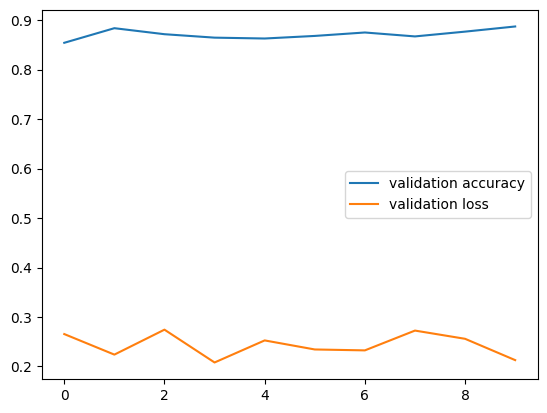

In [30]:
fig = plt.figure(num = 1)
fig2 = fig.add_subplot(1,1,1)
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.plot(total_loss_val, label = 'validation loss')

plt.legend()
plt.show()

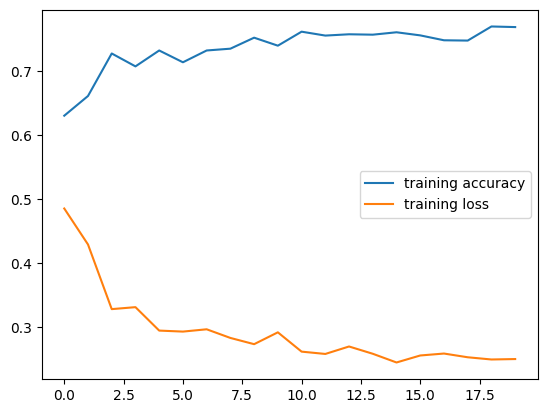

In [31]:
fig = plt.figure(num=1)
fig1 = fig.add_subplot(1,1,1)
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.plot(total_loss_train, label = 'training loss')

plt.legend()
plt.show()

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

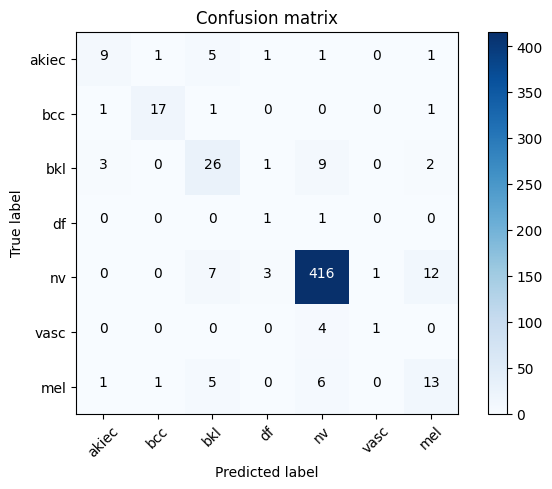

In [34]:
# Validation data evaluation

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

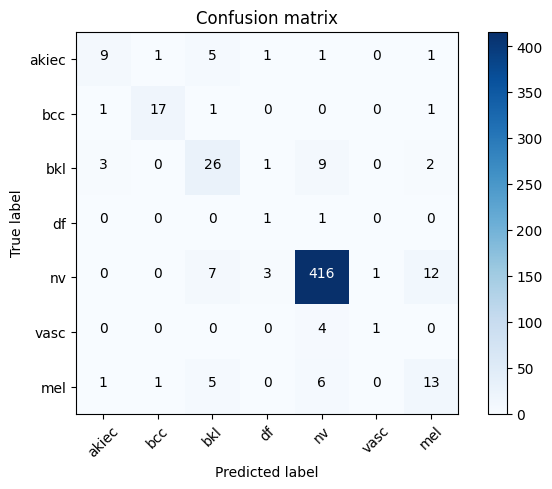

In [35]:
# Test data evaluation

model.eval()
test_y_label = []
test_y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        test_y_label.extend(labels.cpu().numpy())
        test_y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx_test = confusion_matrix(test_y_label, test_y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [36]:
# Generate a validation classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.64      0.50      0.56        18
         bcc       0.89      0.85      0.87        20
         bkl       0.59      0.63      0.61        41
          df       0.17      0.50      0.25         2
          nv       0.95      0.95      0.95       439
        vasc       0.50      0.20      0.29         5
         mel       0.45      0.50      0.47        26

    accuracy                           0.88       551
   macro avg       0.60      0.59      0.57       551
weighted avg       0.88      0.88      0.88       551



In [37]:
# Generate a test classification report
report = classification_report(test_y_label, test_y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.47      0.75      0.58        12
         bcc       0.82      0.60      0.69        15
         bkl       0.65      0.60      0.62        47
          df       0.67      0.67      0.67         6
          nv       0.96      0.97      0.96       444
        vasc       1.00      0.88      0.93         8
         mel       0.37      0.35      0.36        20

    accuracy                           0.89       552
   macro avg       0.71      0.69      0.69       552
weighted avg       0.90      0.89      0.89       552



Text(0, 0.5, 'Fraction classified incorrectly')

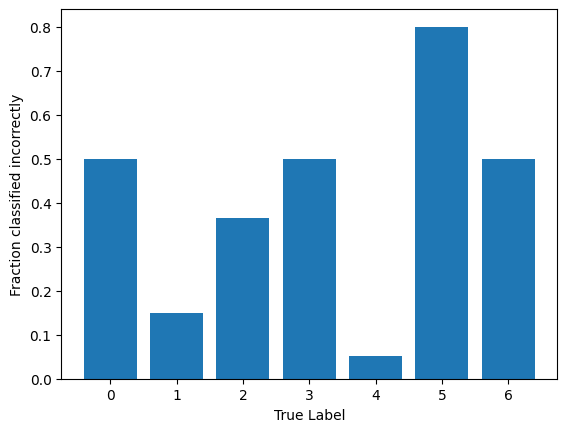

In [38]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

Text(0, 0.5, 'Fraction classified incorrectly')

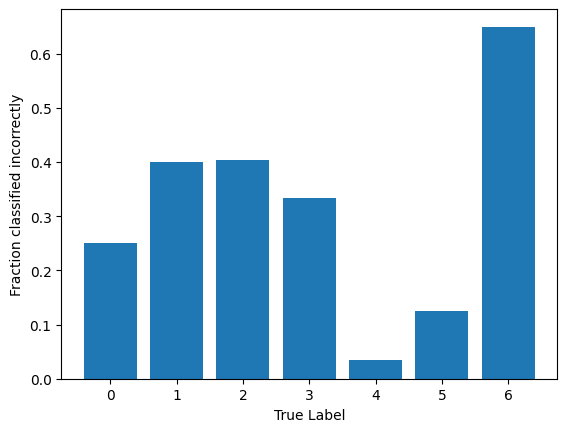

In [39]:
label_frac_error = 1 - np.diag(confusion_mtx_test) / np.sum(confusion_mtx_test, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

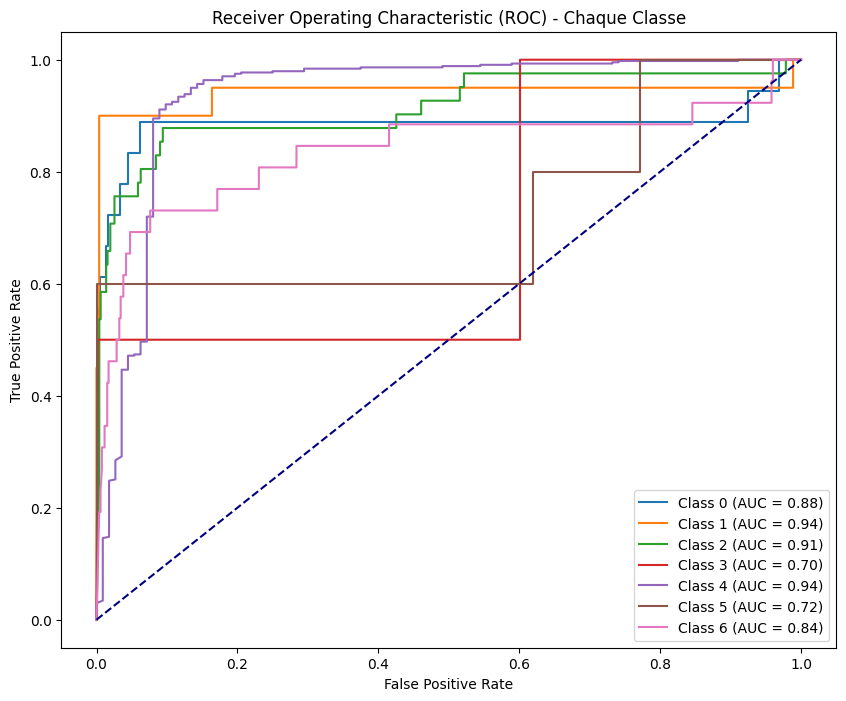

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
import numpy as np
from sklearn.preprocessing import label_binarize

def plot_roc_for_classes(model, val_loader, num_classes, device):
    """
    Fonction pour tracer la courbe ROC pour chaque classe.
    :param model: Modèle PyTorch.
    :param val_loader: DataLoader pour l'ensemble de validation.
    :param num_classes: Nombre de classes.
    :param device: Le périphérique (GPU ou CPU).
    """
    # Initialisation des labels et des probabilités prédites
    y_true = []
    y_scores = []

    model.eval()  # Mettre le modèle en mode évaluation

    with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Passer les images à travers le modèle
            outputs = model(images)
            
            # Calculer les probabilités via softmax
            probabilities = torch.softmax(outputs, dim=1)
            
            # Ajouter les véritables labels et les probabilités prédites
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    # Convertir les labels en format binaire (1 par classe)
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    # Tracer la courbe ROC pour chaque classe
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        # Calculer la courbe ROC
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array([score[i] for score in y_scores]))
        roc_auc = auc(fpr, tpr)
        
        # Tracer la courbe ROC
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    # Tracer la ligne de non-séparation
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

    # Ajouter les labels et légende
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Chaque Classe')
    plt.legend(loc='lower right')

    # Afficher le graphique
    plt.show()

# Exemple d'utilisation (après l'évaluation du modèle)
num_classes = 7  # Nombre de classes dans votre dataset
plot_roc_for_classes(model, val_loader, num_classes, device)


In [41]:
torch.save(model.state_dict(), '/kaggle/working/model39.pth')
